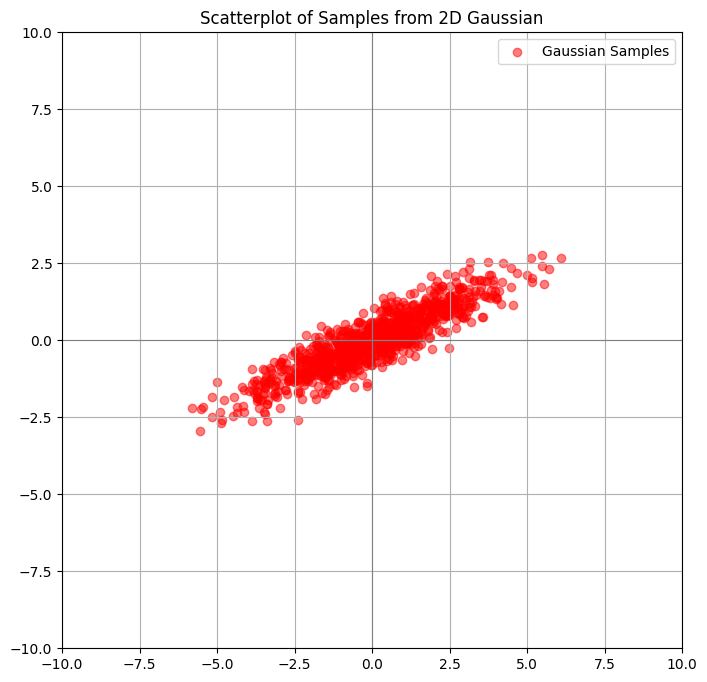

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_gaussian_samples(mu, cov, num_samples=500, ax=None, color='blue', label=''):
    samples = np.random.multivariate_normal(mu, cov, num_samples)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, c=color, label=label)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.axhline(0, color='grey', lw=0.8)
    ax.axvline(0, color='grey', lw=0.8)
    ax.grid(True)
    ax.legend()
    ax.set_title('Scatterplot of Samples from 2D Gaussian')
    return ax

mu = np.array([0, 0])
cov = np.array([[4, 1.8], [1.8, 1]])  # Positive correlation example

fig, ax = plt.subplots(figsize=(8, 8))
plot_gaussian_samples(mu, cov, num_samples=1000, ax=ax, color='red', label='Gaussian Samples')
plt.show()


[0.5 4. ]


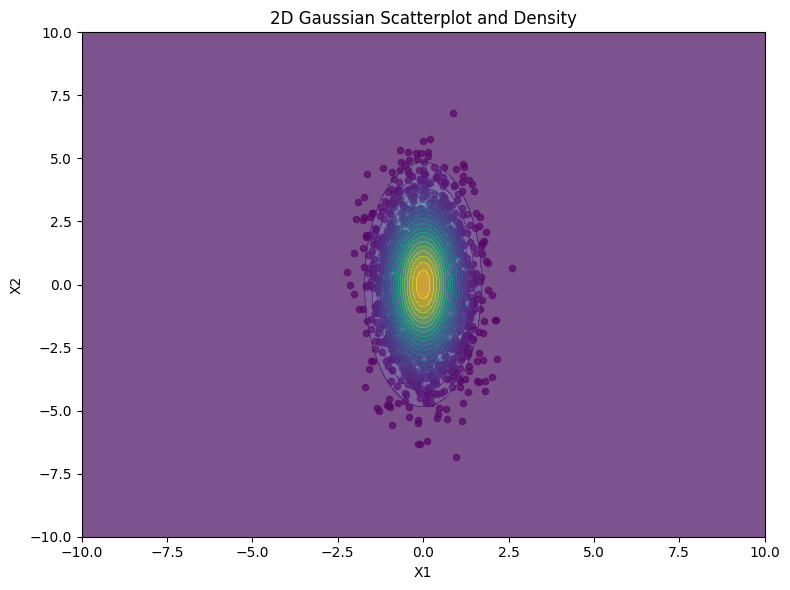

In [27]:
# Mean and covariance for 2D Gaussian
mu = np.array([0, 0])
cov = np.array([[0.5, 0],
                [0, 4]])

print(np.linalg.eigvals(cov))
# Generate random samples
num_samples = 2000
samples = np.random.multivariate_normal(mu, cov, num_samples)

# Scatter plot of the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=20, color='purple', alpha=0.7)

# Overlay density contours (heatmap)
x = np.linspace(-10, 10, 300)
y = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)

plt.title("2D Gaussian Scatterplot and Density")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go

mu = np.array([0, 0, 0])
cov = np.array([[4, 1, 0.5],
                [1, 2, 0.2],
                [0.5, 0.2, 3]])
n_points = 50

eigvals, eigvecs = np.linalg.eigh(cov)

# Generate data for unit sphere
u = np.linspace(0, 2 * np.pi, n_points)
v = np.linspace(0, np.pi, n_points)

x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))

# Scale and rotate the sphere to match Gaussian ellipsoid
radii = np.sqrt(eigvals)
ellipsoid = np.array([x.flatten(), y.flatten(), z.flatten()])
scaled = np.dot(np.diag(radii), ellipsoid)
rotated = np.dot(eigvecs, scaled).T
x_ellip = rotated[:, 0].reshape(n_points, n_points) + mu[0]
y_ellip = rotated[:, 1].reshape(n_points, n_points) + mu[1]
z_ellip = rotated[:, 2].reshape(n_points, n_points) + mu[2]

# Plot with Plotly
fig = go.Figure(data=[go.Surface(x=x_ellip, y=y_ellip, z=z_ellip, opacity=0.7, colorscale='Viridis')])
fig.update_layout(title='3D Gaussian Ellipsoid', scene=dict(aspectmode='data'))
fig.show()


In [11]:
s = "tonmoy"
for i in s:
    print(ord(i) - 97)

19
14
13
12
14
24
